In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [3]:
# Portfolio weights are based on the Cbus Super “Growth (MySuper)” investment option as published in its 31 December 2024 portfolio disclosure. Asset exposures are mapped to representative ETFs for simulation purposes.
portfolio_weights = {
    'VAS.AX': 0.22,        # Australian equity
    'IVV': 0.25,           # Intl developed equity
    'VAF.AX': 0.18,        # Fixed income
    'VNQ': 0.07,           # Property
    'IFRA': 0.10,          # Infrastructure
    'AAA.AX': 0.10,        # Cash
    'IEM.AX': 0.08         # Emerging markets
}


In [4]:
# Setup time horizon
start_date = "2020-06-19"
end_date = "2025-06-18"

tickers = list(portfolio_weights.keys())

# Download Data
raw_data = yf.download(tickers, start=start_date, end=end_date, progress=False)

price_data = raw_data["Close"]
price_data.head(10)

YF.download() has changed argument auto_adjust default to True


Ticker,AAA.AX,IEM.AX,IFRA,IVV,VAF.AX,VAS.AX,VNQ
Date,,,,,,,
2020-06-19,44.317307,53.758430,21.324478,287.708282,47.884918,62.083874,66.175201
2020-06-22,44.326160,53.776711,21.433140,289.770599,47.866787,62.075672,66.109108
2020-06-23,44.334995,53.877186,21.378813,290.950287,47.821484,62.141304,65.836441
2020-06-24,44.334995,54.343063,20.799292,283.602417,47.794292,62.256218,63.960835
2020-06-25,44.330574,53.676220,20.905235,286.575012,47.857727,60.803627,64.777740
2020-06-26,44.326160,54.142097,20.527645,279.738068,47.875854,61.640701,63.534416
2020-06-29,44.334995,53.036781,21.206772,283.936859,47.866787,60.705147,64.761047
2020-06-30,44.334995,53.877186,21.469362,287.680450,47.866787,61.640701,65.528748
2020-07-01,44.334515,53.330193,21.287357,289.649780,47.779564,61.917225,67.039078


In [5]:
price_data.fillna(method='ffill', inplace=True)
price_data.fillna(method='bfill', inplace=True)

/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_3460/4023545668.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='ffill', inplace=True)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_3460/4023545668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.fillna(method='ffill', inplace=True)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_3460/4023545668.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data.fillna(method='bfill', inplace=True)
/var/folders/dm/6bz8tqrj0y508xhhny9v1f4r0000gn/T/ipykernel_3460/4023545668.py:2: SettingWithCopyWarning:

In [6]:
# NAV for the portfolio
normalized_prices = price_data / price_data.iloc[0]
weights_series = pd.Series(portfolio_weights)
portfolio_nav = normalized_prices.dot(weights_series)
portfolio_nav

Date
2020-06-19    1.000000
2020-06-22    1.002182
2020-06-23    1.002895
2020-06-24    0.992807
2020-06-25    0.990840
                ...   
2025-06-11    1.622486
2025-06-12    1.624794
2025-06-13    1.613735
2025-06-16    1.619574
2025-06-17    1.612654
Length: 1290, dtype: float64

In [7]:
# Build the maximum drawdown label for the next 20 days
forward_days = 20
forward_max = portfolio_nav.shift(-forward_days).rolling(forward_days).max()
drawdown = (forward_max - portfolio_nav) / forward_max
threshold = 0.05
y = (drawdown > threshold).astype(int)

# Build Features
X = pd.DataFrame(index=portfolio_nav.index)
X["ret_5d"] = portfolio_nav.pct_change(5)
X["ret_20d"] = portfolio_nav.pct_change(20)
X["vol_20d"] = portfolio_nav.pct_change().rolling(20).std()

# contract the final training dataset
df = pd.concat([X, y.rename("target")], axis=1).dropna()
df


,ret_5d,ret_20d,vol_20d,target
Date,,,,
2020-07-17,0.010965,0.020549,0.004994,0
2020-07-20,0.010058,0.017122,0.005010,0
2020-07-21,0.018084,0.026532,0.005407,0
2020-07-22,0.007056,0.035782,0.004746,0
2020-07-23,0.008541,0.034605,0.004800,0
...,...,...,...,...
2025-06-11,0.007912,0.025435,0.004468,0
2025-06-12,0.010536,0.022366,0.004406,0
2025-06-13,-0.000344,0.009170,0.004574,0


In [8]:
X = df[["ret_5d", "ret_20d", "vol_20d"]]
y = df["target"]
pd.Series(y).value_counts()

# Split the test set and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [9]:
# Model Setup
base_model = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(class_weight="balanced", solver="liblinear"))
])

# fit the training set
base_model.fit(X_train, y_train)

# Predicting the test set
y_pred = base_model.predict(X_test)
y_proba = base_model.predict_proba(X_test)[:, 1] 

#Verify the class labels
base_model.classes_

array([0, 1])

In [10]:
acc_train = accuracy_score(y_train, base_model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print (f'Train Accuracy:{acc_train:0.4},Test Accuracy:{acc_test:0.4}')

Train Accuracy:0.7402,Test Accuracy:0.8504


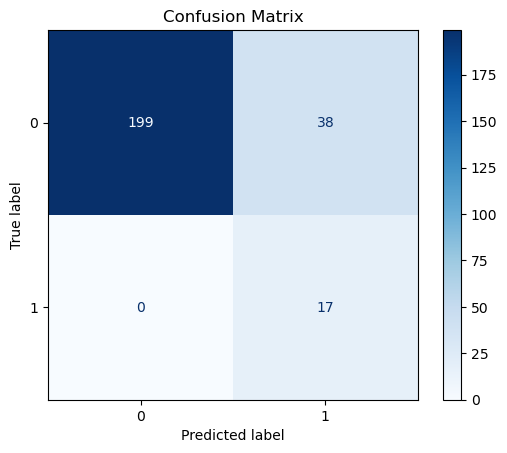

In [11]:
# Display confussion matrix
ConfusionMatrixDisplay.from_estimator(base_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       237
           1       0.31      1.00      0.47        17

    accuracy                           0.85       254
   macro avg       0.65      0.92      0.69       254
weighted avg       0.95      0.85      0.88       254

Confusion Matrix:
[[199  38]
 [  0  17]]
AUC Score: 0.9875899726979399


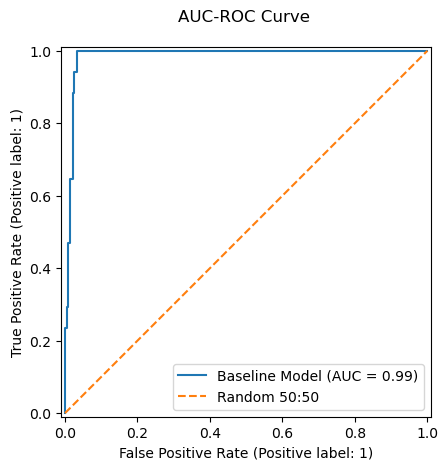

In [12]:
# Moedel Performence 
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("AUC Score:", roc_auc_score(y_test, y_proba))

# Visualize ROC 
display = RocCurveDisplay.from_estimator(base_model, X_test, y_test, name='Baseline Model')
plt.title('AUC-ROC Curve \n')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random 50:50')
plt.legend()
plt.show()